In [68]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
%matplotlib inline

<font size="5">Making a custom power spectrum</font>


Text(0, 0.5, '$D_l$')

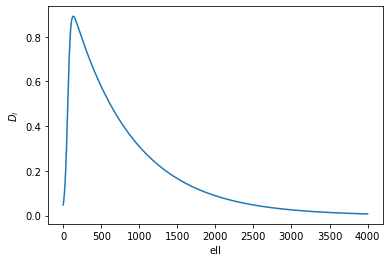

In [69]:
lmax=4000
ell=np.arange(0,lmax+1)

dl=1/(np.exp((60-ell)/20)+np.exp((ell-60)/800))

plt.plot(ell,dl)
plt.xlabel("ell")
plt.ylabel("$D_l$")

Text(0, 0.5, '$ln(D_l)$')

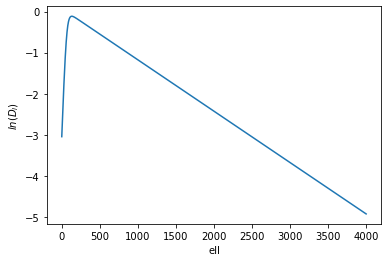

In [70]:
plt.plot(ell,np.log(dl))
plt.xlabel("ell")
plt.ylabel("$ln(D_l)$")

<ipython-input-71-9007cb9dfb48>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)


array([5.40000000e+00, 5.40135034e+00, 5.40270135e+00, ...,
       1.08000000e+04, 2.16000000e+04,            inf])

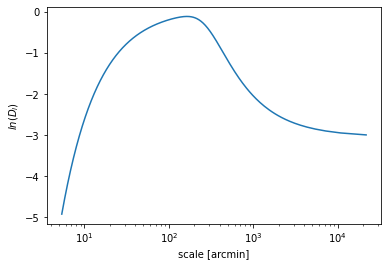

In [71]:
ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)
ellsc=ellsc[::-1]

fdl=dl[::-1]

plt.plot(ellsc,np.log(fdl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')
ellsc

In [72]:
cl = dl * 2 * np.pi / (ell*(ell+1.))
cl[0]=0
cl[1]=0

<ipython-input-72-61d338a088c4>:1: RuntimeWarning: divide by zero encountered in true_divide
  cl = dl * 2 * np.pi / (ell*(ell+1.))


In [73]:
lmax

4000

<font size="5">Making a full sky map</font>


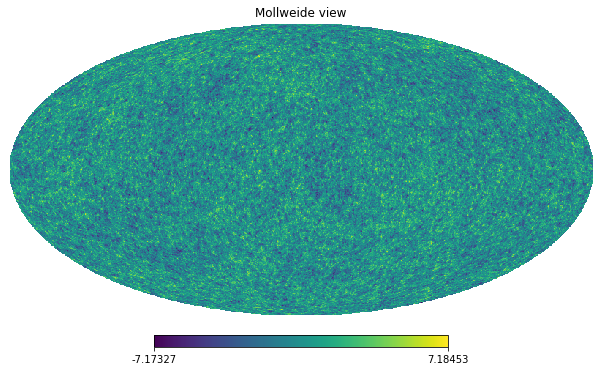

In [74]:
seed = 589
np.random.seed(seed)

alm = hp.synalm((cl), lmax=lmax, new=True)
nside=1024

hmap=hp.alm2map(alm, nside=nside, lmax=lmax)

hp.mollview(hmap)

Calculating the power spectrum from the map

In [75]:
rcl=hp.anafast(hmap,lmax=lmax,use_pixel_weights=True)

rdl=ell * (ell + 1.) * rcl/(np.pi*2)

Text(0, 0.5, '$\\frac{\\ell(\\ell+1)}{2\\pi}C_{\\ell}$')

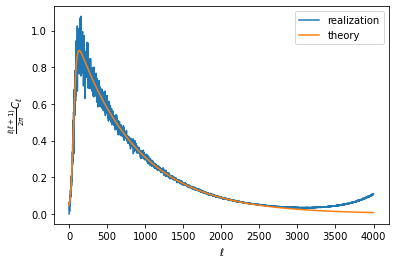

In [76]:
plt.plot(ell,rdl ,label='realization')
plt.plot(ell,dl,label='theory')
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}C_{\ell}$")

<ipython-input-77-3be87fbfde33>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell


Text(0, 0.5, '$ln(D_l)$')

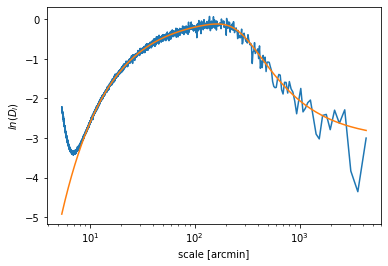

In [77]:
ellsc=21600/ell
ellsc=ellsc[::-1]

fdl=rdl[::-1]
tfdl=dl[::-1]

plt.plot(ellsc[:-5],np.log(fdl[:-5]),label='realization')
plt.plot(ellsc[:-5],np.log(tfdl[:-5]),label='theory')

plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

resolution of the map

In [78]:
nside=hp.npix2nside(len(hmap))
resarc=hp.nside2resol(nside,arcmin=True)
resol=hp.nside2resol(nside)
print("resolution = %.2f arcmin" % resarc)

resolution = 3.44 arcmin


<font size="5">Defining the Wavelets</font>

These are the radial profile of the wavelet in real space

In [79]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=(2*np.pi*sigma*sigma)
    return g

In [80]:
def morlet(f,sigma,theta):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=np.sum(wv)/np.sum(wvm)
    mor=wv-B*wvm
    return mor

In [60]:
def my_gabor(freq,sigma,Theta,Phi):
    
    
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((Theta,Phi), np.complex64)
    [x, y] = np.mgrid[-1*(Theta//2):(Theta//2),-1*(Phi//2):(Phi//2)]
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=(2*np.pi*sigma*sigma)
    return g

In [61]:
def my_morlet(f,sigma, Theta , Phi):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = my_gabor( f , sigma , Theta , Phi)
    wv_modulus = my_gabor(0 , sigma , Theta , Phi)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

Gabor wavelet

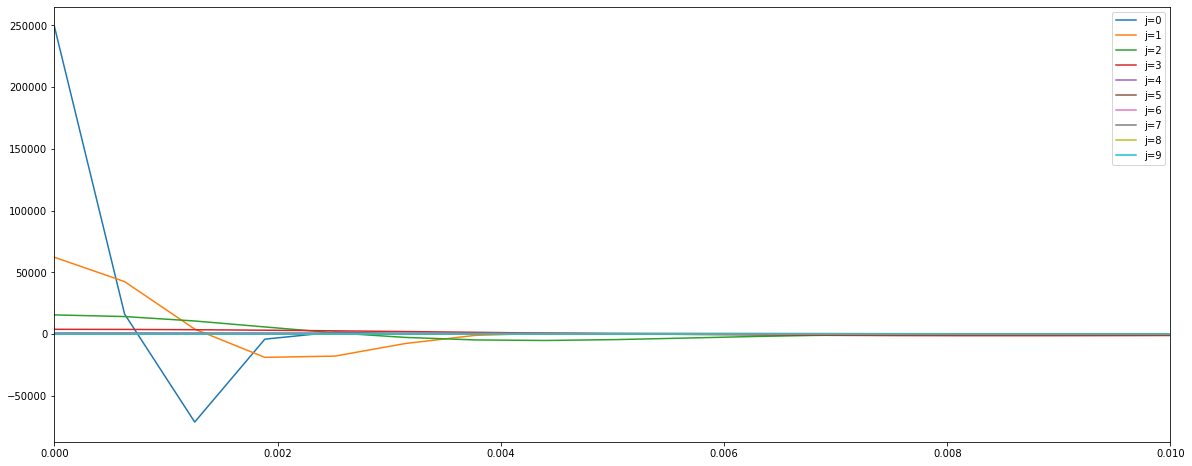

In [46]:
theta=np.linspace(0,np.pi,5000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)

    gb=gabor(freq1,sigma1,theta)

    plt.plot(theta,gb.real,label='j='+str(j))
    plt.legend()
    plt.xlim(0,0.01)

Morlet wavelet

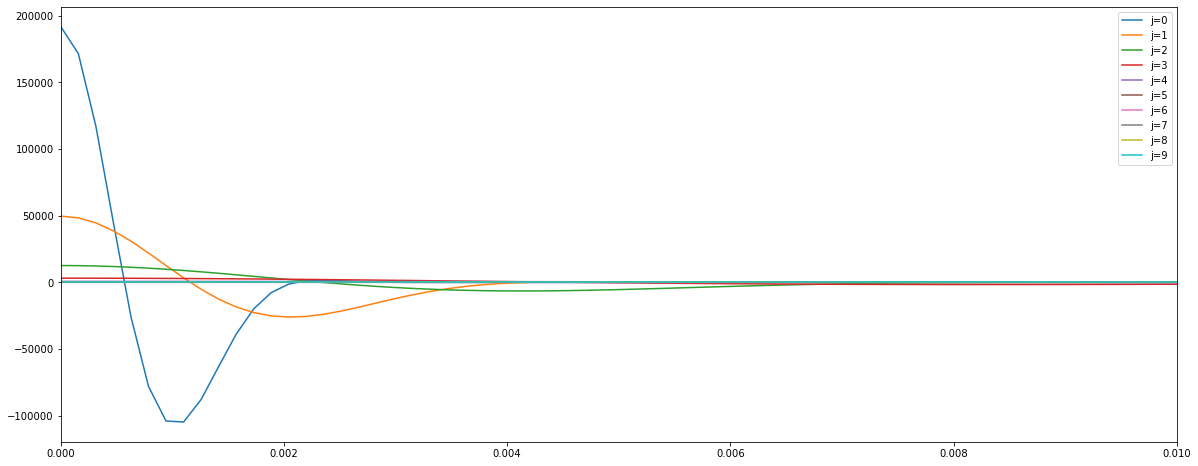

In [47]:
theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)

    mor=morlet(freq1,sigma1,theta)

    plt.plot(theta,mor.real,label='j='+str(j))
    plt.legend()
    plt.xlim(0,0.01)

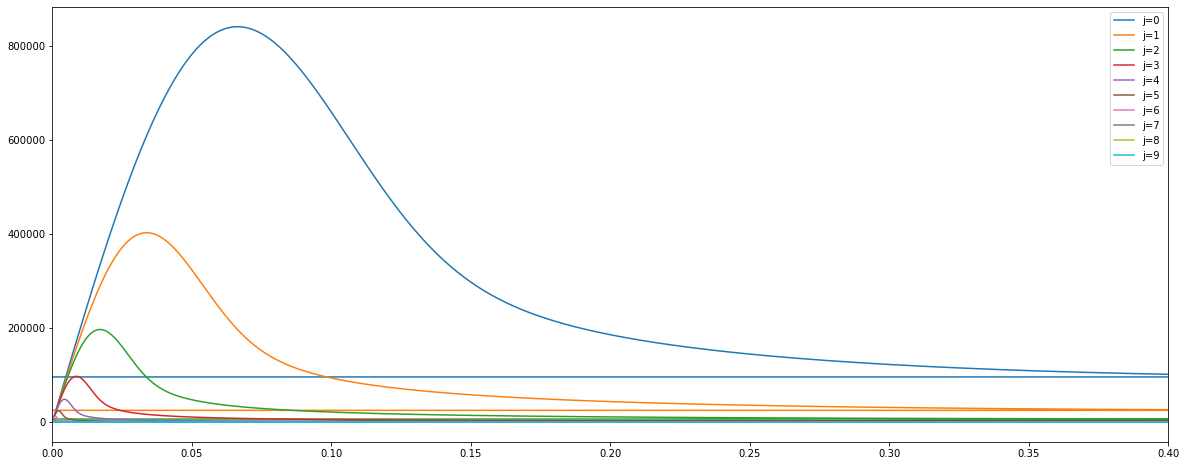

In [94]:
theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)

    mor=morlet(freq1,sigma1,theta)
    mor_fft = np.fft.fft(mor.real )
    #print (mor_fft)
    freq = np.fft.fftfreq(theta.shape[0])
    plt.plot(freq , abs(mor_fft) , label='j='+str(j))
    plt.legend()
    plt.xlim(0,0.4)

Morlet wavelet in the spherical harmonic space

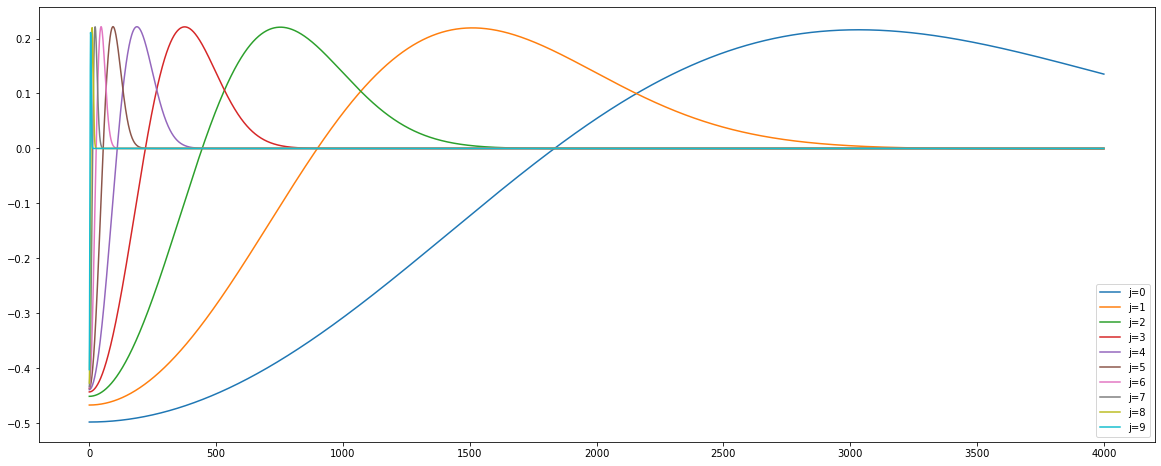

In [127]:
theta=np.linspace(0,np.pi,20000)
#Theta = np.linspace (0,1,1000)  
#Theta = np.deg2rad (Theta)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)

    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor.real,theta,lmax=lmax)
    plt.plot(ell,mor_l,label='j='+str(j))
    plt.legend()
    plt.xlim ()

In [102]:
def my_gauss(theta, sigma):
    
    g = np.exp (- theta**2/(2*sigma**2))/ (2*np.pi*sigma**2)
    return g 

In [ ]:
def my_func (theta ):
    
    g = theta **2

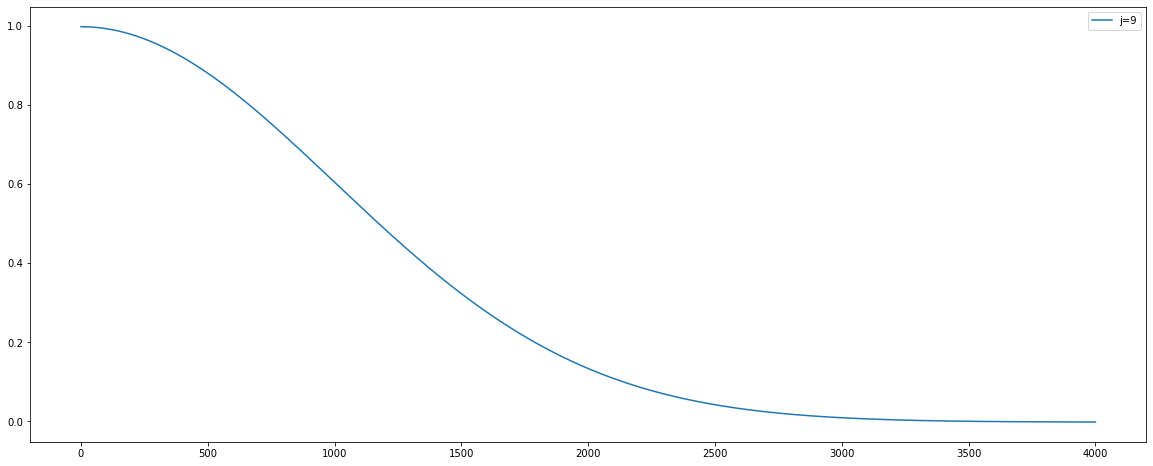

In [118]:
theta=np.linspace(0,np.pi,20000)
#Theta = np.linspace (0,1,1000)  
#Theta = np.deg2rad (Theta)
fig=plt.figure(figsize=[20,8])
#for j in range(1,10):
    #sigma1 = (0.8*2**j)
    #freq1=(3.0*np.pi) /(4.0*2**j)
sigma = resol 
mor=my_gauss(theta , sigma )
mor_l=hp.beam2bl(mor,theta,lmax=lmax)
plt.plot(ell,mor_l,label='j='+str(j))
plt.legend()
#plt.xlim (0,10)

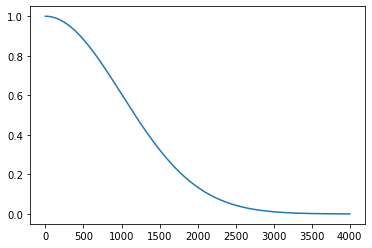

In [125]:
f = hp.gauss_beam(2*np.sqrt(2*np.log(2))*resol , lmax= 4000)
plt.plot(ell,f,label='j='+str(j))
#plt.xlim (0,10)


In [137]:
def flat_gauss (M , N , sigma ):
    
    g = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    arg = -(x**2+y**2)/(2*sigma*sigma) 
    #print (arg.shape)
    g += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    g /= norm_factor

    return g

In [178]:
def fourier_power_spectrum(img_r, img_len, bin_k):
    """
    Compute the Fourier power spectrum given a 2-dimensional real-space map.
    
    Parameters
    ----------
        img_r: arraylike
            2-dimensional real-space map 
            
        img_len: float
            image size 
            (units define output units of wavenumber and power spectrum)
            
        bin_k: int
            number of bins in Fourier space
            
    Returns
    -------
        k: np.ndarray
            wavenumber in units of inverse [img_len]
            
        pk: np.ndarray
            power spectrum in units of [img_len]**2
    """
    assert np.ndim(img_r) == 2, 'img_r is not 2D'
    img_pix = np.size(img_r, axis=0)  # pixel number per axis
    img_dim = np.ndim(img_r)  # image dimension

    # This first 'paragraph' is to create masks of indices corresponding to 
    # one Fourier bin each.
    freq = np.fft.fftfreq(n=img_pix, d=img_len/img_pix) * 2*np.pi
    rfreq = np.fft.rfftfreq(n=img_pix, d=img_len/img_pix) * 2*np.pi
    kx, ky = np.meshgrid(freq, rfreq, indexing='ij')
    k_abs = np.sqrt(kx**2. + ky**2.)
    # The following complicated line is actually only creating a 1D array 
    # spanning k-space logarithmically from minimum k_abs to maximum. To 
    # start slightly below the minimum and finish slightly above the maximum 
    # I use ceil and floor. To ceil and floor not to the next integer but to 
    # the next 15th digit, I multiply by 1e15 before flooring and divide by 
    # the same amount afterwards. Since the ceiled/floored value is actually 
    # the exponent used for the logspace, going to the next integer would be 
    # too much, which is why I do this ceil/floor to digit procedure.
    k_log = np.logspace(np.floor(np.log10(np.min(k_abs[1:]))*1.e15)/1.e15, np.ceil(np.log10(np.max(k_abs[1:]))*1.e15)/1.e15, bin_k)

    img_k = np.fft.rfftn(np.fft.fftshift(img_r)) * (img_len/img_pix)**img_dim
    pk = np.empty(np.size(k_log)-1)
    for i in range(np.size(k_log)-1):
        mask = (k_abs >= k_log[i]) & (k_abs < k_log[i+1])
        pk[i] = np.mean(np.abs(img_k[mask])**2.) / img_len**img_dim

    k = (k_log[1:] + k_log[:-1]) / 2

    return k, pk

In [188]:
def power_axes_k(ax1, ax2):
    ax1.set_xlabel("$k$")
    ax2.set_xlabel("$k$")
    ax1.set_ylabel("$P(k)\ k^2 / (2\pi)^2$")
    ax2.set_ylabel("$P(k)\ k^2 / (2\pi)^2$")

In [179]:
fmap_pwl_1024_k, fmap_pwl_1024_pk = fourier_power_spectrum(mor1, 100, bin_k=256)


/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


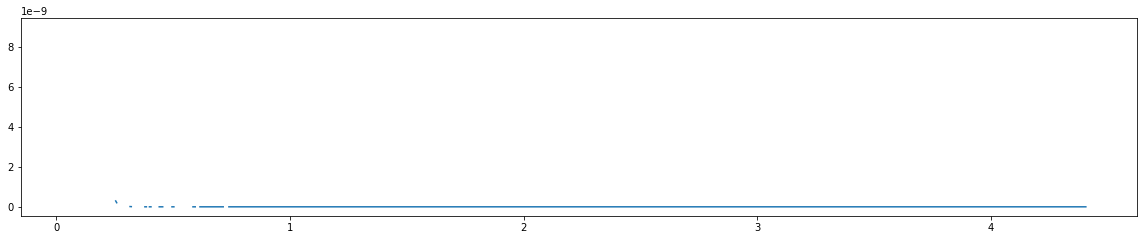

In [203]:
fig = plt.figure(figsize=[20,8])
ax1 = plt.subplot(211)
ax1.plot(fmap_pwl_1024_k, fmap_pwl_1024_k**2/(2*np.pi)**2 * fmap_pwl_1024_pk)
#ax1.set_ylim(min(np.nanmin(fmap_pwl_1024_k[:20]**2/(2*np.pi)**2*fmap_pwl_1024_pk[:20])/10, 
             #np.nanmin(fmap_pwl_1024_k[:20]**2/(2*np.pi)**2*fmap_pwl_1024_pk[:20])/10))



[[0.99999879 0.82086878 0.4540399  ... 0.16922496 0.4540399  0.82086878]
 [0.82086878 0.67382637 0.37270763 ... 0.13891165 0.37270763 0.67382637]
 [0.4540399  0.37270763 0.20615248 ... 0.07683498 0.20615248 0.37270763]
 ...
 [0.16922496 0.13891165 0.07683498 ... 0.02863712 0.07683498 0.13891165]
 [0.4540399  0.37270763 0.20615248 ... 0.07683498 0.20615248 0.37270763]
 [0.82086878 0.67382637 0.37270763 ... 0.13891165 0.37270763 0.67382637]]


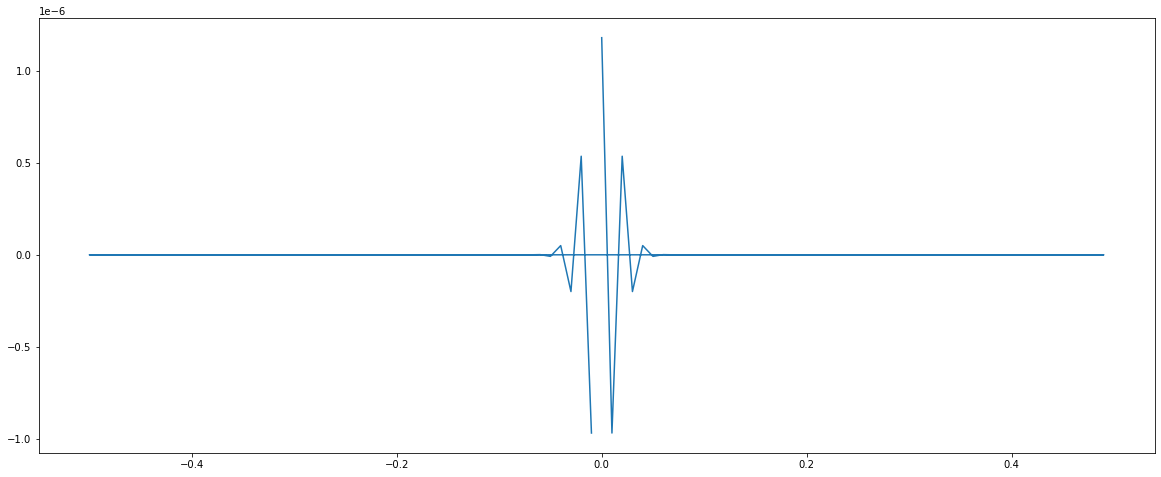

In [176]:
 
mor1=flat_gauss(100, 100, 10)
#print (mor1)
freq = np.fft.fftfreq(100)
#print (freq)
mor1fft=np.real(np.fft.fft2(np.fft.fftshift(mor1)))
mor2fft  = np.real(np.fft.fft2(mor1))
mor3 = mor1[0,:] * np.sqrt (2*np.pi*10)
mor3fft = np.real(np.fft.fft(mor3))
#print (mor2fft)
print (mor1fft)
fig=plt.figure(figsize=[20,8])
plt.plot (freq  , mor3fft )

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [132]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((8))

i1=[]

for j1 in range(8):
    
    sigma1 = (0.8*resol*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
    
    #filter 1
    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor.real,theta,lmax=lmax) 
    
    #convolving the map with filter 1
    mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
    nalm=hp.almxfl(mapalm,mor_l)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    i1.append(I1)
    
    #Gaussian filter for S1
    phi1=gabor(0,sigma1, theta)
    gab_l=hp.beam2bl(phi1.real,theta,lmax=lmax)
    
    #Convolving with gaussian filter to get S1
    I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    nI1alm=hp.almxfl(I1alm,gab_l)
    S1map=hp.alm2map(nI1alm,nside,lmax)
    
    #Averaging the entire map
    S1[j1]=np.mean(S1map)

CPU times: user 7min 37s, sys: 6.06 s, total: 7min 43s
Wall time: 2min 47s


Text(0.5, 1.0, 'S1 coefficients')

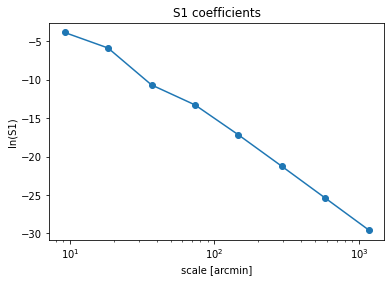

In [131]:
Jf=np.arange(8)
scale=2**Jf*((2*resarc)/0.75)

plt.plot(scale,np.log(S1),marker='o')
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.title("S1 coefficients")

In [40]:
print(len(i1))
print(i1[0].shape)

8
(12582912,)


In [42]:
%%time

S2=np.zeros((8,8))

for j1 in range(8):
    I1=i1[j1]
    
    for j2 in range (8):
                
        sigma2 = (0.8*resol*2**j2)
        freq2=(3.0*np.pi) /(4.0*resol*2**j2)
        
        #filter 2        
        mor2=morlet(freq2,sigma2,theta)
        mor_l2=hp.beam2bl(mor2.real,theta,lmax=lmax)
        
        #Convolving I1 with filter 2
        mapalm2=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
        nalm2=hp.almxfl(mapalm2,mor_l2)
        I2=hp.alm2map(nalm2,nside,lmax)
        
        #modulus
        I2=np.abs(I2)
        
        #Gaussian filter to get S2
        phi2=gabor(0,sigma2, theta)
        gab_l2=hp.beam2bl(phi2.real,theta,lmax=lmax)
    
        #Convolving with gaussian filter to get S2
        I2alm=hp.map2alm(I2,lmax=lmax,use_pixel_weights=True)
        nI2alm=hp.almxfl(I2alm,gab_l2)
        S2map=hp.alm2map(nI2alm,nside,lmax)     
                       
        #averaging the entire map
        S2[j1][j2]=np.mean(S2map)
    print(j1)

0
1
2
3
4
5
6
7
CPU times: user 1h 38min 41s, sys: 51.1 s, total: 1h 39min 32s
Wall time: 29min 24s


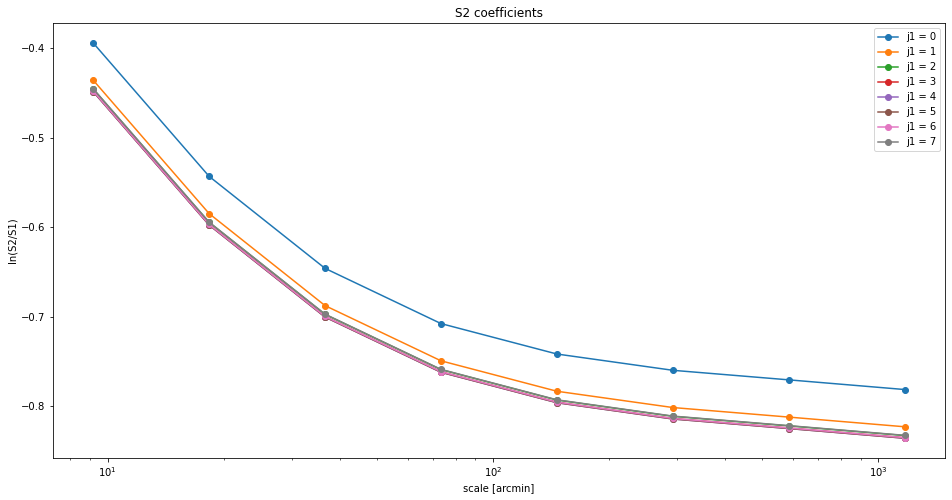

In [44]:
fig=plt.figure(figsize=[16,8])
for j in range (8):
    plt.plot(scale,np.log(S2[j]/S1[j]),marker='o',label="j1 = "+str(j))
    plt.xscale('log')
    plt.xlabel("scale [arcmin]")
    plt.legend(loc='best')
    plt.ylabel("ln(S2/S1)")
    plt.title("S2 coefficients")